# Problem need to be addressed 

In this research, we proposal a new fault tolerance analysis technique - fault tolerance boundary is designed specific to the data variables.
1. What's the fault tolerance boundary.
2. It's a technique can be equivlent to the fault injection campaign.
3. We propose a method to approximate the boundary.
    1. heuristic method to measure the boundary.
    2. correlation analysis between variables to understand the relationship between the fault tolerance across variables.
4. label propagation and active learning.
5. The why masked prediction fail also can we use the SDC run to predict the program's outcome

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random
import math
from IPython.core.debugger import set_trace
from datetime import datetime
import sys
random.seed(datetime.now())

In [2]:
DATASET = "fft" #current available datasets fft, lu, cg, other potential dataset.,

In [3]:
# Threshold that used to decide whether the final outcome is SDC or Masked. For the loading data
# set, there are two different datasets. One is the exhaust fault injection campaign which contains
# all the fault injection information. The other is the test data set which is the sample experiment 
# contain the detail propagation information used for the downstream propagation analysis.
PROPAGATION_DATA_PATH = ""
CAMPAIGN_DATA_PATH = ""
PROPAGATION_INJECTION_DATA_PATH = ""
THRESHOLD = 0

if DATASET == "fft":
    PROPAGATION_DATA_PATH = "../static/data/fft/fft_complete"
    CAMPAIGN_DATA_PATH = "../static/data/fft/fft_injectlog.log"
    THRESHOLD = 0.001
elif DATASET == "cg":
    PROPAGATION_DATA_PATH = "../static/data/cg/cg_in8"
    CAMPAIGN_DATA_PATH = "../static/data/cg/cg_in8/injectlog.log"
    THRESHOLD = 0.07
elif DATASET == "lu":
    PROPAGATION_DATA_PATH = "../static/data/lu/lu20000"
    CAMPAIGN_DATA_PATH = "../static/data/lu/injectlog.log"
    THRESHOLD = 0.0001
elif DATASET == "bs":
    PROPAGATION_DATA_PATH = "../static/data/bs/bs"
    CAMPAIGN_DATA_PATH = "../static/data/bs/injectlog_complete.log"
    THRESHOLD = 0.0001
     
# The fault injection campaign experiment
FAULT_INJECTION_CAMPAIGN = pd.read_csv(CAMPAIGN_DATA_PATH,  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# The size of the fault injection experiment
SIZE = len(FAULT_INJECTION_CAMPAIGN)

# The percentage of the test experiment over exhaust fault injection campaign.
TEST_EXPERIMENT_NUMBER = int(SIZE * 0.01)

# Golden Run
GOLDEN_RUN = pd.read_csv(PROPAGATION_DATA_PATH+"/golden.log",  sep=" ", names=['file', 'linenum', 'variable', 'value'])

# Subset of fault injection campaign that used to verify the quality of a dynamic instruction
# FAULT_INJECTION_TEST_CAMPAIGN = pd.read_csv(TEST_PATH, sep=",")
#TEST_EXPERIMENTS = FAULT_INJECTION_CAMPAIGN.sample(n=TEST_EXPERIMENT_NUMBER, replace=False,  random_state=1)

TEST_EXPERIMENTS = pd.read_csv(PROPAGATION_DATA_PATH+"/injectlog.log",  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# SDC ratio of test experiments
SDC_COUNT = 0
for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
    if float(row['diffnorm']) > THRESHOLD:
        SDC_COUNT += 1

print("The SDC ratio in this experiment is",SDC_COUNT/len(FAULT_INJECTION_CAMPAIGN))
print("The size of the experiment is",  len(TEST_EXPERIMENTS))
print("The size of the exhaust fault injection experiments", len(FAULT_INJECTION_CAMPAIGN))

C:\Users\zhimin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The SDC ratio in this experiment is 0.08332608904737948
The size of the experiment is 20000
The size of the exhaust fault injection experiments 2162624


# Golden Fault Injection Boundary
Golden fault injection boundary use the exhaust fault inject campaign to build the boundary in practical sense. If the error value is above a specific threshold, then the location will not tolerance the error.

In [4]:
# In fault injection campaign analysis, the prediction outcome is positive and negative.
# during the prediction process, we ignore the crash case.
# For the prediction, we need to think about four different cases
# True negative, False positive
# False negative, True positive
def predict(boundary):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []
    nan = float('nan')
    inf = float('inf')

    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = 0
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        
        if init_value != 0 and corrupt_value != nan and corrupt_value != inf:
            inject_error = abs((corrupt_value - init_value)/init_value)
        
        diffnorm = float(row['diffnorm'])
        if inject_error < boundary[instruction_index]:
            #bits.append(row["bit"])
            if diffnorm < THRESHOLD:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"] = crash
    result["accuracy"] = positive_prediction/(positive_prediction + crash + negative_prediction)
    
    return (result, bits)

def getGoldenFaultToleranceBoundary():
    boundary = {}
    nan = float('nan')
    inf = float('inf')
    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        inject_error = 0
        norm = float(row["diffnorm"])
        
        try:
            instruction_index = int(row["byte_num"].split("#")[1])
        except:
            print(row)
        
        if init_value != 0 and corrupt_value != nan and corrupt_value != inf:
            inject_error = abs((corrupt_value - init_value)/init_value)
  
        if instruction_index not in boundary:
            boundary[instruction_index] = float("+inf")
        
        if norm > THRESHOLD:
            if boundary[instruction_index] > inject_error:
                boundary[instruction_index] = inject_error    
    return boundary

boundary = getGoldenFaultToleranceBoundary()
print(predict(boundary)[0])

{'positive': 1949238, 'negative': 0, 'crash': 2219, 'accuracy': 0.9988629008991743}


# A Single Fault Injection Experiment

Understand how a single fault injection experiment can help to understand the result of the other fault injection experiment.

Randomly select 1000 fault injection experiments and test the prediction accuracy of each masked experiment.

In [5]:
#The number of fault injection experiments that a single fault injection can predict is masked.
def single_masked_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001): 
    # The experiment ends early
    if len(fault_inject_run) < len(golden_run):
        print("Bad fault injection experiment!")
        return False
    
    # Get the prediction boundary of a single fault injection experiment.
    boundary = np.abs(np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float"))    
    if np.isnan(boundary).any() or np.isinf(boundary).any():
        print("This experiment outcome is masked, but the propagation process contains nan or infinity event")
        return False
    
    # The number of tested experiment
    # print(len(experiments))
    
    positive_prediction = 0
    negative_prediction = 0
    SDC_count = 0
    crash = 0
    count = len(experiments)
  
    for index, row in experiments.iterrows():
        
        #if pd.isna(row["byte_num"]):
        #    continue
        
        #print(row['byte_num'], np.isnan(row["byte_num"]))
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = abs(float(row["corrupt_value"]) - float(row["init_value"]))
        diffnorm = float(row['diffnorm'])
        
        if inject_error <= boundary[instruction_index]:
            if diffnorm < threshold:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    if (positive_prediction + negative_prediction) is 0:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "accuracy":0,  "total":positive_prediction+negative_prediction}    
    else:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "total":positive_prediction+negative_prediction, "accuracy":positive_prediction/(positive_prediction + negative_prediction+crash)}  

#The number of fault injection experiment that the program can predict as SDC
def single_SDC_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001):
    pass

In [22]:
# During the fault injection experiment, filter out the bad prediction case and left with the good prediction case.
GOOD_MASKED_RUN = []

In [23]:
diffnorms = np.array(FAULT_INJECTION_CAMPAIGN.diffnorm, dtype='float')
length = len(TEST_EXPERIMENTS)
list_indexs = []
pre_res = {}
index = 0

sample_dataset = FAULT_INJECTION_CAMPAIGN.sample(n=int(TEST_EXPERIMENT_NUMBER/10), replace=False,  random_state=1)
#Understand the pruning technique.
print(len(sample_dataset))

for i, row in TEST_EXPERIMENTS.iterrows():
    file_index = row["fileindex"]
    norm = float(row["diffnorm"])
    
    
    if index > int(TEST_EXPERIMENT_NUMBER/10):
        break
    index += 1
    if index % (length/10) ==0:
        print(index/float(length), "experiment")
    
    #verify the select fault injection experiment is valuable
    if norm != 0 and not np.isinf(norm) and not math.isnan(norm) and norm < THRESHOLD :
        fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        pre_res = single_masked_prediction(fault_inject_run, GOLDEN_RUN, sample_dataset, THRESHOLD)
        
        #if the predictor reject the current experiment for prediction, continue to next experiment
        if not pre_res:
            continue
        
        if pre_res['accuracy'] >= 1 :
            GOOD_MASKED_RUN.append(file_index)
        
        list_indexs.append({"diffnorm":math.log10(norm), "index":index, "crash":pre_res["crash"], "negative":pre_res["negative"], "positive":pre_res["positive"], 'accuracy':pre_res['accuracy']})


2162
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
This experiment outcome is masked, but the propagation process contains nan or infinity event
0.1 experiment


In [24]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
fig = plt.figure()
list_indexs = sorted(list_indexs, key = lambda i: i['diffnorm']) 
x = []
y = []
z = []
k = []
for i in range(len(list_indexs)):
    x.append(list_indexs[i]['diffnorm'])
    y.append(list_indexs[i]['positive'] + list_indexs[i]['negative'] + list_indexs[i]['crash'])
    z.append(list_indexs[i]['negative'])
    k.append(list_indexs[i]['accuracy'])

In [25]:
print(list_indexs)

[{'diffnorm': -13.546681659952963, 'index': 1, 'crash': 0.0, 'negative': 0.0, 'positive': 0.0666049953746531, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 36, 'crash': 0.0, 'negative': 0.009250693802035153, 'positive': 0.07724329324699353, 'accuracy': 0.893048128342246}, {'diffnorm': -13.546681659952963, 'index': 42, 'crash': 0.0, 'negative': 0.0, 'positive': 0.04394079555966698, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 45, 'crash': 0.0, 'negative': 0.0, 'positive': 0.09204440333024977, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 51, 'crash': 0.0, 'negative': 0.0, 'positive': 0.08649398704902868, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 58, 'crash': 0.0, 'negative': 0.0, 'positive': 0.04440333024976873, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 73, 'crash': 0.0, 'negative': 0.0, 'positive': 0.09250693802035152, 'accuracy': 1.0}, {'diffnorm': -13.546681659952963, 'index': 80, 'crash': 0.0, 'negat

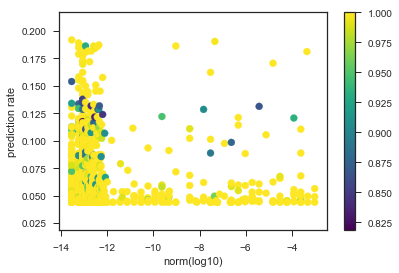

In [26]:
sns.set(style="ticks")
sns.axes_style('white')
df = pd.DataFrame(data = {"x":x, "y":y, "k":k,"z":z})

plt.scatter(x, y, c=k, cmap='viridis')
plt.xlabel('norm(log10)')
plt.ylabel('prediction rate')
#plt.clim(0,1)
plt.colorbar()
plt.show()

Text(0.5,0,'negative prediction')

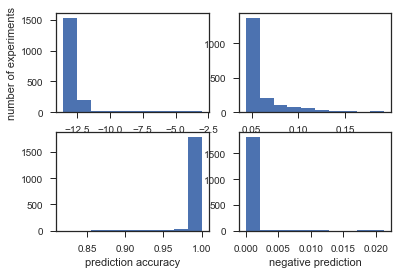

In [27]:
plt.subplot(2, 2, 1)
plt.hist(df.x)
plt.xlabel('norm')
plt.ylabel('number of experiments')

plt.subplot(2, 2, 2)
plt.hist(df.y)
plt.xlabel('positive prediction')

plt.subplot(2, 2, 3)
plt.hist(df.k)
plt.xlabel('prediction accuracy')

plt.subplot(2, 2, 4)
plt.hist(df.z)
plt.xlabel('negative prediction')

# We use 1000 experiments as a filter to filter out outlier propagation data

1. here is a very interesting, we use the subset of the sample to filter the outlier propagation data. Why this type of data is outlier

In [35]:
tracking_length = len(GOLDEN_RUN.value)
def construct_boundary(cases):
    boundary = []
    for i in range(tracking_length):
        boundary.append(0)

    for i in range(len(cases)):
        index = cases[i]
        #masked_run_path = "../static/data/cg/cg_in8/appstate_"+ str(index)+".log" 
        masked_run_path = PROPAGATION_DATA_PATH +"/appstate_"+ str(index) + ".log"
        #Check whether the tracking file is on the path
        #TODO: check whether can regenerate the data
        #print(masked_run_path)
        if not os.path.isfile(masked_run_path):
            print("file does not exist")
            continue

        masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['file', 'linenum', 'variable', 'value'])
        masked_run_value = np.array(masked_run.value, dtype='float')
        
        #This is a werid information in the data.
        #TODO: may check why such outcome is shown
        if len(masked_run_value) < tracking_length:
            print("odd!")
            continue

        #array contain NAN, ignore the run
        if np.isnan(np.min(masked_run_value)):
            continue

        comparision_result = np.abs(masked_run_value[0:tracking_length] - GOLDEN_RUN.value)
        for j in range(tracking_length):
            if comparision_result[j] > boundary[j]:
                boundary[j] = comparision_result[j]
                
    return boundary

def predict(boundary):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []

    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row["DI"]) 
        
        inject_error = abs(row["out_xor"])
        diffnorm = float(row['diffnormr'])
        
        if inject_error <= boundary[instruction_index]:
            bits.append(row["bit"])
            if diffnorm < THRESHOLD:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"] = crash
    result["accuracy"] = positive_prediction/(positive_prediction + crash + negative_prediction)
    
    return (result, bits)

In [37]:
import dill
dill.dump_session('notebook_env.db')

ModuleNotFoundError: No module named 'dill'

In [2]:
import dill
dill.load_session('notebook_env.db')

In [3]:
print(GOOD_MASK)
#boundary = construct_boundary(GOOD_MASKED_RUN)

KeyboardInterrupt: 

In [36]:
res, bits = predict(boundary)
plt.hist(bits)
print(res)
#plt.hist(df.x)
#plt.xlabel('norm')
#plt.ylabel('number of experiments')

KeyError: 'DI'

In [ ]:
#plot the boundary
plt.plot(boundary)

# Extracting A single fault injection site to understand the error propagation.